# Imports

In [1]:
import os 

os.chdir('../')
os.getcwd()

'/Users/celsloaner/git/QTensor'

In [2]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.21.2', 'qiskit-aer': '0.11.0', 'qiskit-ignis': '0.7.0', 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.38.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [3]:
# Qtensor branch: dev
from qiskit import QuantumCircuit, execute, Aer, QuantumRegister, transpile, IBMQ
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from qtensor import QAOAComposer
from qtensor import CirqQAOAComposer, QtreeQAOAComposer
from qtensor import NoisyQtreeQAOAComposer

2023-09-06 23:48:14,446- WARNING•	QuickBB solver is unavailable
2023-09-06 23:48:14,448- WARNING•	Tamaki solver is unavailable: No path /Users/celsloaner/opt/anaconda3/envs/mod_qtensor/lib/python3.8/site-packages/thirdparty/tamaki_treewidth. Either install tamaki in /Users/celsloaner/opt/anaconda3/envs/mod_qtensor/lib/python3.8/site-packages/thirdparty/tamaki_treewidth or add `tw-heuristic` to your $PATH
/Users/celsloaner/opt/anaconda3/envs/mod_qtensor/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils

In [4]:
import numpy as np


def bit_count(arr):
    # Make the values type-agnostic (as long as it's integers)
    t = arr.dtype.type
    mask = t(-1)
    s55 = t(0x5555555555555555 & mask)  # Add more digits for 128bit support
    s33 = t(0x3333333333333333 & mask)
    s0F = t(0x0F0F0F0F0F0F0F0F & mask)
    s01 = t(0x0101010101010101 & mask)

    arr = arr - ((arr >> 1) & s55)
    arr = (arr & s33) + ((arr >> 2) & s33)
    arr = (arr + (arr >> 4)) & s0F
    return (arr * s01) >> (8 * (arr.itemsize - 1))


def precompute_vectorized_cpu_parallel(weighted_terms, offset, N):
    state_indices = np.arange(2**N)
    term_v = np.zeros_like(state_indices, dtype=np.float64)
    for coeff, pos in weighted_terms:
        a = sum([2**x for x in pos])
        tmp = np.bitwise_and(a, state_indices)
        term_v += coeff * (1 - 2 * (bit_count(tmp) % 2))
    term_v += offset
    return term_v

In [5]:
# Hamiltonian layer
def zz_term(qc, q1, q2, gamma):
    qc.cx(q1,q2)
    qc.rz(2*gamma, q2)
    qc.cx(q1,q2)

def get_cost_circuit(qc, G, gamma):
    N = G.number_of_nodes()
    for i, j in G.edges():
        zz_term(qc, i, j, gamma)
    return qc

# Mixer layer
def x_term(qc, q1, beta):
    qc.rx(2*beta, q1)

def get_mixer_circuit(qc, G, beta):
    N = G.number_of_nodes()
    for n in G.nodes():
        x_term(qc, n, beta)
    return qc

# Combine two layers and get the QAOA circuit
def get_qaoa_circuit(G, gamma, beta, sv=False):
    p = len(beta) # infering number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)

    # get the initial state
    qc.h(range(N))
    # second, apply p alternating operators
    for i in range(p):
        qc = get_cost_circuit(qc,G,gamma[i])
        qc = get_mixer_circuit(qc,G,beta[i])
    # finally, do not forget to measure the result!
    qc.barrier(range(N))
    if sv is False:
        qc.measure(range(N), range(N))
    return qc

In [6]:
def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}

def maxcut_obj(x,G):
    ''' calculate energy from one bitstring '''
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            # the edge is cut
            cut -= 1
    return cut

def compute_maxcut_energy(counts, G):
    ''' calculate energy from samples '''
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        obj_for_meas = maxcut_obj(meas, G)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy / total_counts

In [7]:
def compute_maxcut_energy_sv(counts, G):
    """Compute energy expectation from full state vector"""
    expectation_value = 0
    # convert state vector to dictionary
    counts = state_to_ampl_counts(counts)
    for (meas, wf) in counts.items():
        obj_for_meas = maxcut_obj(meas, G)
        expectation_value += obj_for_meas * (np.abs(wf) ** 2) 
    return expectation_value

def state_num2str(basis_state_as_num, nqubits):
    return "{0:b}".format(basis_state_as_num).zfill(nqubits)

def state_str2num(basis_state_as_str):
    return int(basis_state_as_str, 2)

def state_reverse(basis_state_as_num, nqubits):
    basis_state_as_str = state_num2str(basis_state_as_num, nqubits)
    new_str = basis_state_as_str[::-1]
    return state_str2num(new_str)

def state_to_ampl_counts(vec, eps=1e-15):
    """
    Converts a statevector to a dictionary
    of bitstrings and corresponding amplitudes
    """
    qubit_dims = np.log2(vec.shape[0])
    if qubit_dims % 1:
        raise ValueError("Input vector is not a valid statevector for qubits.")
    qubit_dims = int(qubit_dims)
    counts = {}
    str_format = "0{}b".format(qubit_dims)
    for kk in range(vec.shape[0]):
        val = vec[kk]
        if val.real**2 + val.imag**2 > eps:
            counts[format(kk, str_format)] = val
    return counts

def get_adjusted_state(state):
    """
    Convert qubit ordering invert for state vector
    https://github.com/rsln-s/QAOA_tutorial/blob/main/Hands-on.ipynb
    """
    nqubits = np.log2(state.shape[0])
    if nqubits % 1:
        raise ValueError("Input vector is not a valid statevector for qubits.")
    nqubits = int(nqubits)

    adjusted_state = np.zeros(2**nqubits, dtype=complex)
    for basis_state in range(2**nqubits):
        adjusted_state[state_reverse(basis_state, nqubits)] = state[basis_state]
    return adjusted_state

# Creating a circuit

### QAOA problem graph

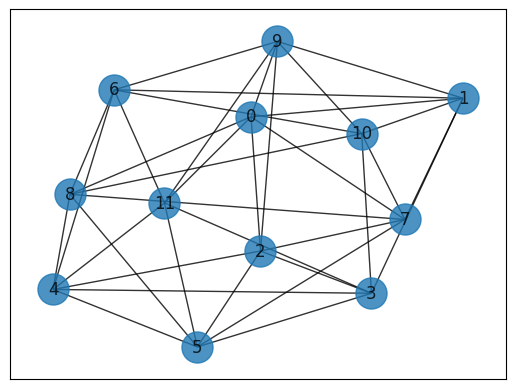

In [8]:
# Generate random graph
d = 6
num_qubits = 12
G = nx.random_regular_graph(d=d, n=num_qubits, seed=12345)
nx.draw_networkx(G, with_labels=True, alpha=0.8, node_size=500)

In [9]:
# G = nx.erdos_renyi_graph(4, 2/(5-1))
# nx.draw_kamada_kawai(G, with_labels=True)

# Noisy tests

## IBM simulation

In [10]:
p = 1
gamma = [.5]*p
beta = [.5]*p

In [11]:
from qtensor import QiskitQAOAComposer

In [12]:
# qiskit_qaoa = QiskitQAOAComposer(G, gamma=gamma, beta=beta)
# qiskit_qaoa.ansatz_state()
# qiskit_qaoa.circuit.measure_all()
# qiskit_qaoa.circuit.draw('mpl')

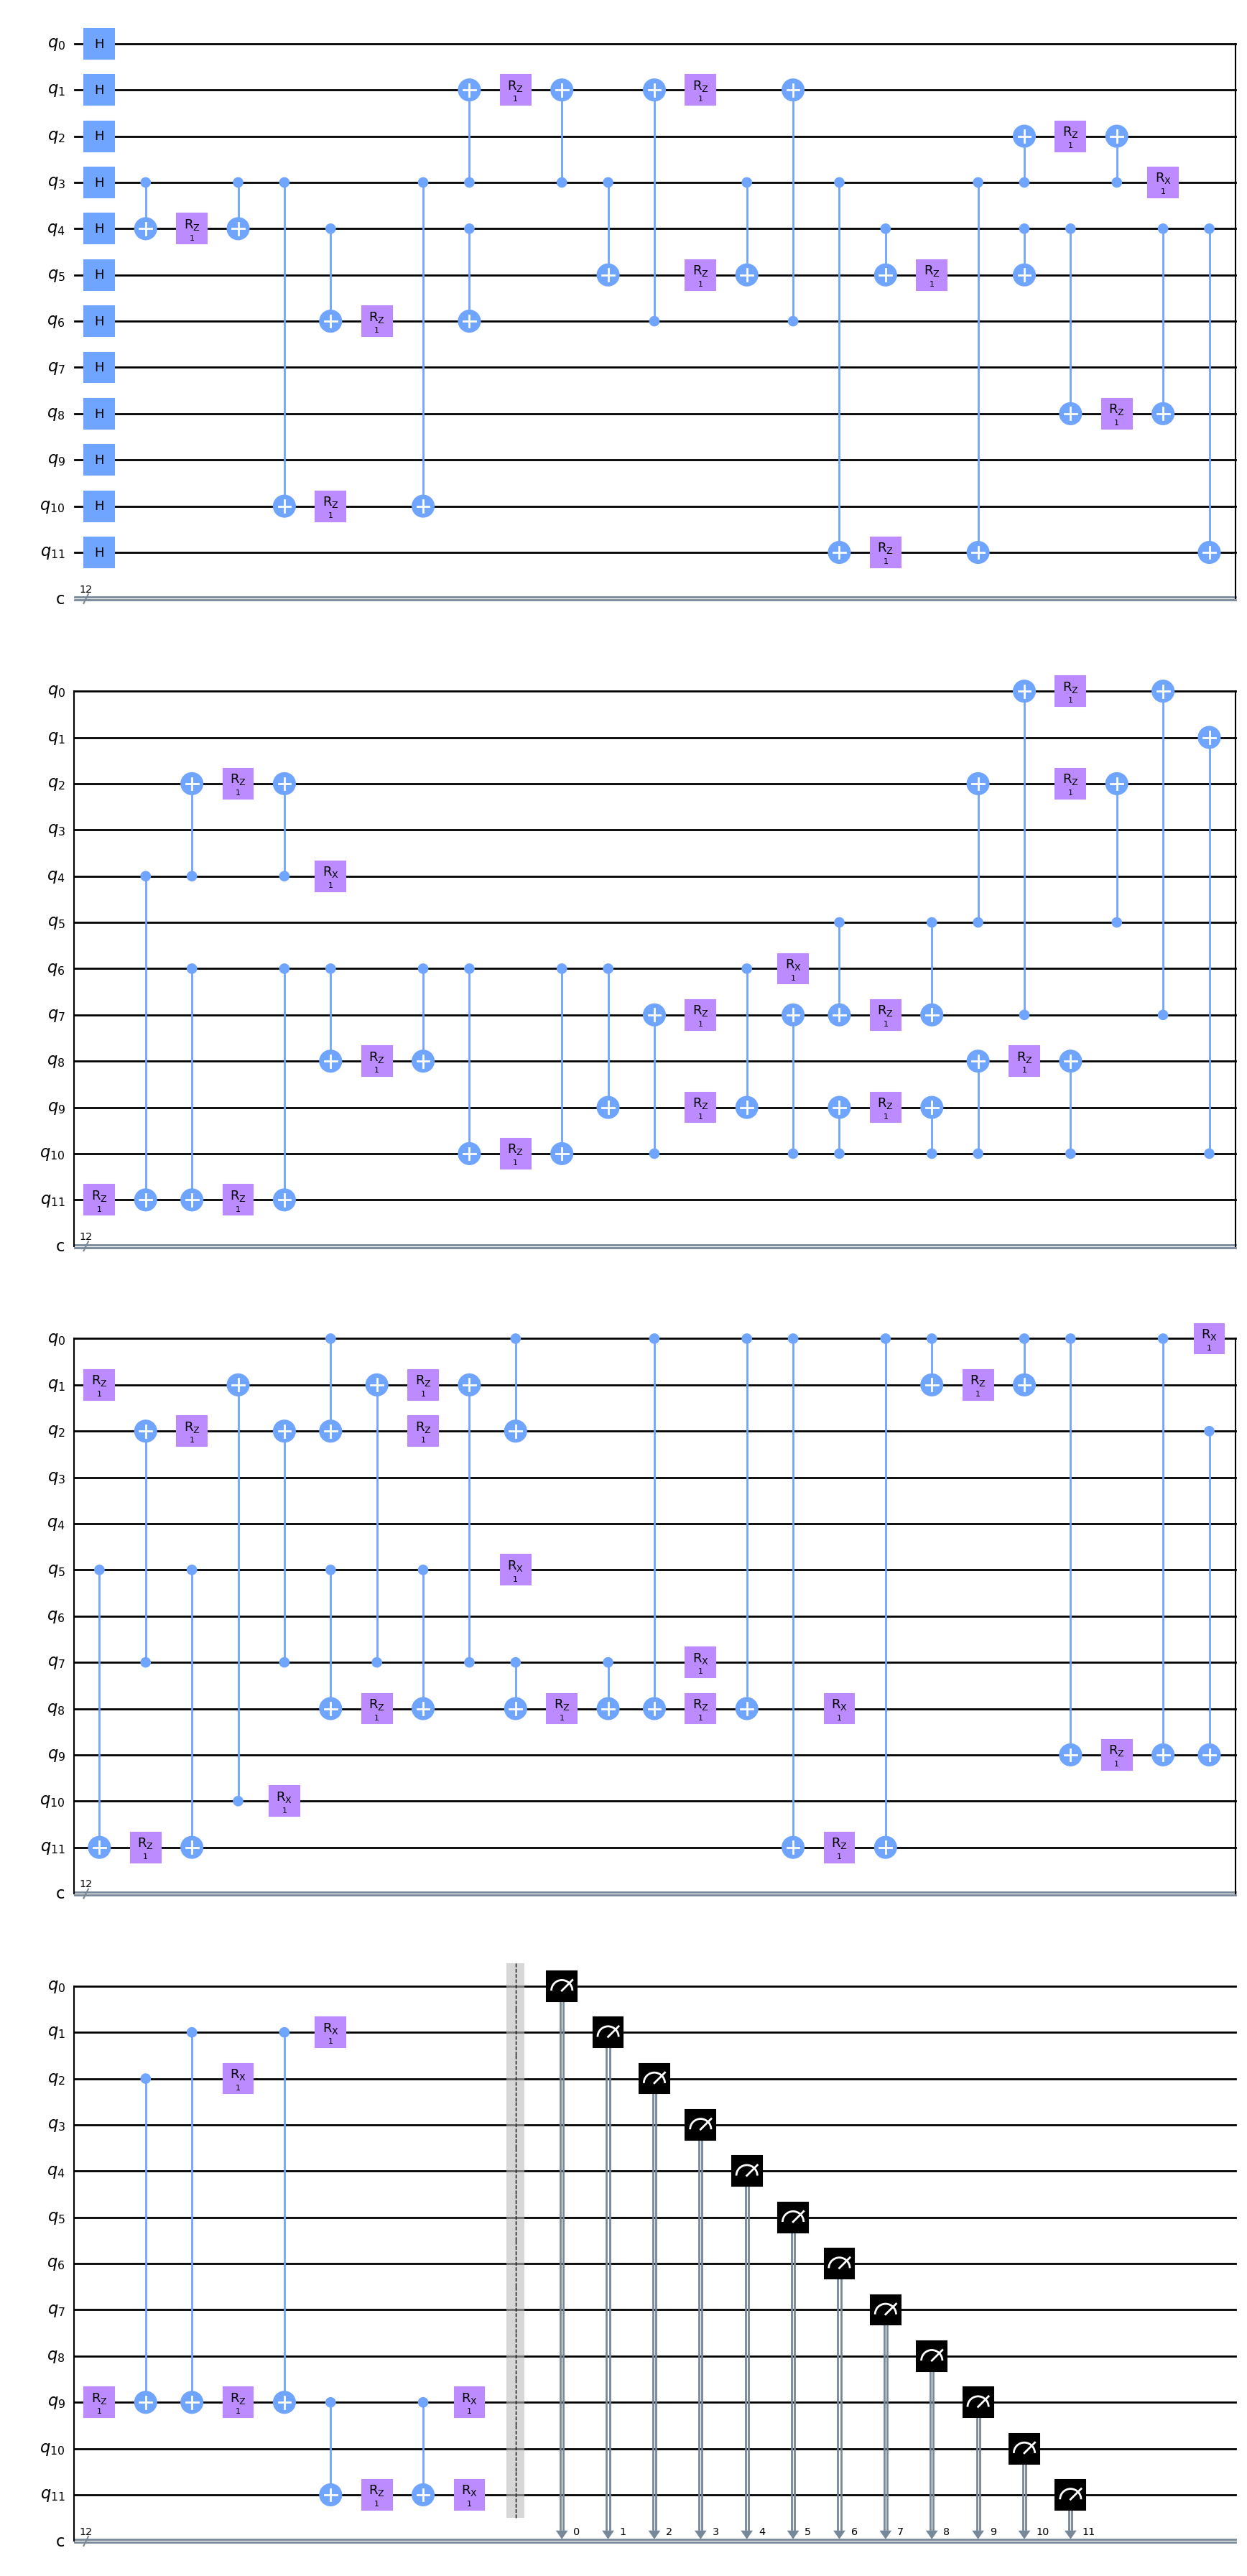

In [13]:
circuit = get_qaoa_circuit(G, gamma, beta)
circuit.draw('mpl')

In [14]:
from qiskit import IBMQ, execute
from qiskit.tools.monitor import job_monitor

# Run on local simulator
simulator = qiskit.Aer.get_backend('aer_simulator')
# simulator = Aer.get_backend("statevector_simulator")

In [15]:
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit.providers.fake_provider import FakeJakartaV2

# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
error_gate1 = depolarizing_error(0.05, 1)
error_gate2 = error_gate1.tensor(error_gate1)
noise_model.add_all_qubit_quantum_error(error_gate1, ['rz', 'rx', 'h'])
noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rx', 'rz', 'sx']
  Instructions with noise: ['h', 'rx', 'cx', 'rz']
  All-qubits errors: ['rz', 'rx', 'h', 'cx']


In [16]:
circuit = get_qaoa_circuit(G, gamma, beta)
shots = 10**6

# Run and get counts
# print(f"Executing circuit with {len(circuit)} gates using {shots} shots.")
job = execute(circuit, backend=simulator, shots=shots)
counts = job.result().get_counts()
counts = invert_counts(counts)

# Compute expactation value
ideal_value = compute_maxcut_energy(counts, G)
print('ideal value = ', ideal_value)

# Run and get counts
# print(f"Executing circuit with {len(circuit)} gates using {shots} shots.")
job = execute(circuit, backend=simulator, noise_model=noise_model, shots=shots)
counts = job.result().get_counts()
counts = invert_counts(counts)

# Compute expactation value
noisy_value = compute_maxcut_energy(counts, G)
print('noisy value = ', noisy_value)

ideal value =  -17.026924
noisy value =  -17.852498


In [17]:
# # Use state vector simulator 
# from qiskit.providers.fake_provider import FakeJakartaV2
# from qiskit.providers.aer.noise import NoiseModel
# from qiskit.providers.aer import AerSimulator

# circuit = get_qaoa_circuit(G, gamma, beta, sv=True)

# # Run and get statevector
# job = execute(circuit, backend=simulator, noise_model=noise_model)
# result = job.result()
# state = job.result().get_statevector()
# state = get_adjusted_state(state)
# print(state)

# # Compute expactation value
# noisy_value = compute_maxcut_energy_sv(state, G)
# noisy_value

In [18]:
# import qiskit.providers.aer.noise as noise
# from qiskit.providers.aer import AerSimulator

# # Take the Qiskit circuit we created before, and add some final touches to it. These do not effect any measurement outcomes 
# qiskit_circ = circuit

# # Qiskit uses little endian notation by default, and Qtensor uses big endian, so we change the Qiskit circuit to match qtensor
# qiskit_circ = qiskit_circ.reverse_bits()
# qiskit_circ.save_density_matrix()
# qiskit_circ.measure_all(add_bits = False)

# # Simulate the circuit
# backend = AerSimulator(method='density_matrix', noise_model=noise_model, fusion_enable=False, fusion_verbose=True)
# result = backend.run(qiskit_circ).result()

# # The stochastic noisy simulation gives us a probability density vector, so we need to save the diagonal elements of the density matrix for our comparison
# qiskit_probs = np.diagonal(np.asarray(result.results[0].data.density_matrix).real)
# qiskit_probs

# # Compute expactation value
# noisy_value = compute_maxcut_energy_sv(qiskit_probs, G)
# noisy_value

## QTensor simulation

In [19]:
from qtensor.QAOASimulator import QAOAQtreeSimulator
from qtensor import QtreeQAOAComposer
from qtensor import NoisyQtreeQAOAComposer
from qtensor import NoisyQAOAQtreeSimulator

## Ideal sim

In [20]:
qtensor_gamma = [param/np.pi for param in gamma]
qtensor_beta = [param/np.pi for param in beta]

In [21]:
qaoa_sim = QAOAQtreeSimulator(QtreeQAOAComposer)

qaoa_sim.energy_expectation(G, gamma=qtensor_gamma, beta=qtensor_beta)

Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 44.43it/s, Treewidth=6]

array([17.02556714])

In [22]:
# qaoa_sim_noisy = QAOAQtreeSimulator(NoisyQtreeQAOAComposer)

qaoa_sim_noisy = NoisyQAOAQtreeSimulator(QtreeQAOAComposer, p_noise=0.05)

num_shots = 100
E_total = 0
for _ in range(num_shots):
    E_total += qaoa_sim_noisy.energy_expectation(G, gamma=qtensor_gamma, beta=qtensor_beta)
E_avg = -E_total/num_shots

Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 46.50it/s, Treewidth=5]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 46.82it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 41.49it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 46.19it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 44.61it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 38.84it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 43.26it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 45.81it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 44.47it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:01<00:00, 35.50it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 46.50it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 45.09it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 37.73it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 46.71it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 46.02it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 42.87it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 39.35it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 48.17it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 49.79it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 40.61it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 49.43it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 53.39it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 44.39it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 53.37it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 51.21it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 53.30it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 45.23it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 53.06it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 55.75it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 53.37it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 44.47it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 55.01it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 53.09it/s, Treewidth=8]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 44.61it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 55.72it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 54.65it/s, Treewidth=5]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 43.78it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 54.55it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 55.78it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 54.60it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 45.30it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 54.33it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 53.31it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 44.40it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 54.43it/s, Treewidth=8]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 53.65it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 40.32it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 49.13it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 51.11it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 51.84it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 41.53it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 53.65it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 52.65it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 45.05it/s, Treewidth=8]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 54.34it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 51.94it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 43.75it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 53.47it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 54.18it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 54.57it/s, Treewidth=7]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 46.10it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 55.13it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 55.26it/s, Treewidth=5]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 45.54it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 53.10it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 52.66it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 45.17it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 55.12it/s, Treewidth=7]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 55.98it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 54.86it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 55.61it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 44.80it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 49.68it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 54.25it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 45.78it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 54.71it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 54.17it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 44.31it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 53.57it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 54.52it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 49.71it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 45.18it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 54.27it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 52.47it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 44.46it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 54.62it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 52.46it/s, Treewidth=5]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 53.46it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 44.94it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 52.34it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 55.91it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 51.95it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 44.61it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 54.83it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 53.89it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 56.14it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 44.56it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 52.91it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 53.31it/s, Treewidth=6]


Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 53.15it/s, Treewidth=6]

In [25]:
print(E_avg)
print(noisy_value)
# print(np.abs(E_avg - noisy_value) <= 0.1)

[-17.62022421]
-17.852498


In [24]:
qaoa_sim_noisy.energy_expectation(G, gamma=qtensor_gamma, beta=qtensor_beta)

Edge iteration: 100%|██████████████| 36/36 [00:00<00:00, 41.87it/s, Treewidth=6]

array([17.33120232])